# Task 1 — Student Score Prediction (Kaggle Dataset)

**Goal:** Predict student exam scores based on study hours and other factors.  
**Steps covered:**
- Load & clean dataset
- Exploratory Data Analysis (EDA)
- Train/Test Split
- Linear Regression (hours only)
- Polynomial Regression (hours only)
- Random Forest (multi-feature, tuned with RandomizedSearchCV)
- XGBoost (if installed)
- Final comparison of models


In [57]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [47]:
# Load dataset
df = pd.read_csv("StudentPerformanceFactors.csv")  

# Normalize column names
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r"[^a-z0-9]+", "_", regex=True)
              .str.strip("_")
)
print(df.shape)
df.head()


(6607, 20)


,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,family_income,teacher_quality,school_type,peer_influence,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [48]:
# Detect target and hours column
cols = df.columns.tolist()
target_candidates = ["exam_score", "score", "final_score", "marks", "exam_marks"]
hours_candidates  = ["hours_studied", "study_hours", "hours", "studying_hours"]

def pick_column(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

target_col = pick_column(target_candidates, cols)
hours_col  = pick_column(hours_candidates, cols)

print("Detected target:", target_col)
print("Detected hours feature:", hours_col)

# Clean numeric
df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
df[hours_col]  = pd.to_numeric(df[hours_col], errors="coerce")
df = df.dropna(subset=[target_col, hours_col])
df.shape


Detected target: exam_score
Detected hours feature: hours_studied


(6607, 20)

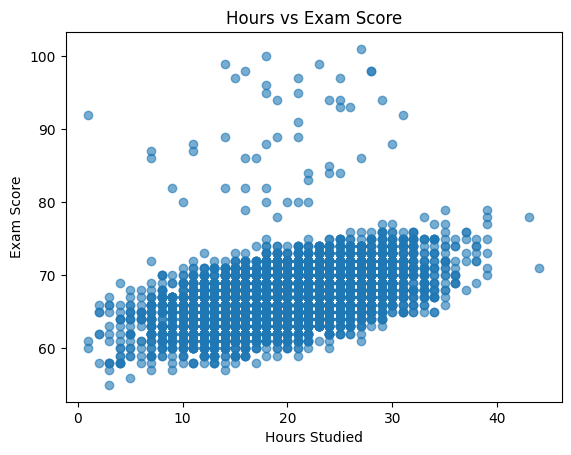

In [49]:
# Scatter plot: Hours vs Exam Score
plt.scatter(df[hours_col], df[target_col], alpha=0.6)
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Hours vs Exam Score")
plt.show()


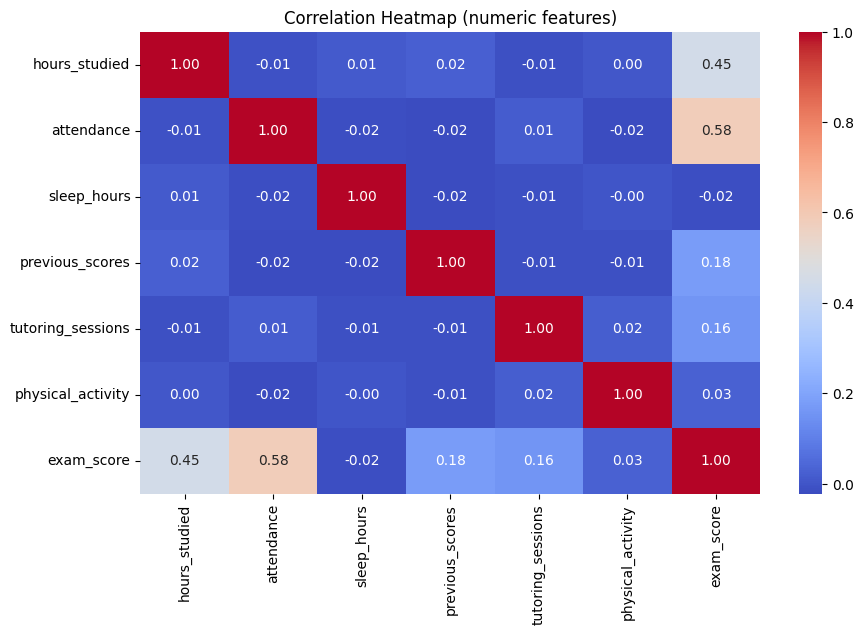

exam_score           1.000000
attendance           0.581072
hours_studied        0.445455
previous_scores      0.175079
tutoring_sessions    0.156525
physical_activity    0.027824
sleep_hours         -0.017022
Name: exam_score, dtype: float64

In [50]:
import seaborn as sns

# Correlation of numeric features with target
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (numeric features)")
plt.show()

# Focus only correlation with exam score
corr[target_col].sort_values(ascending=False)


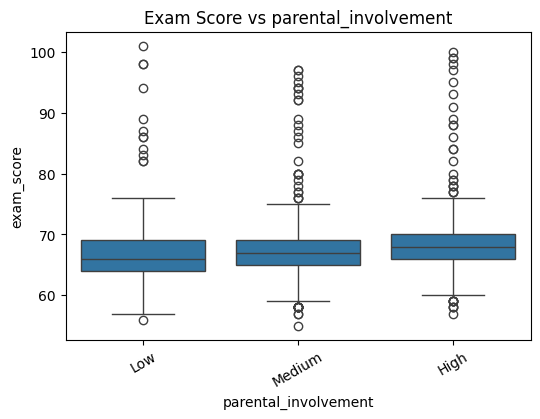

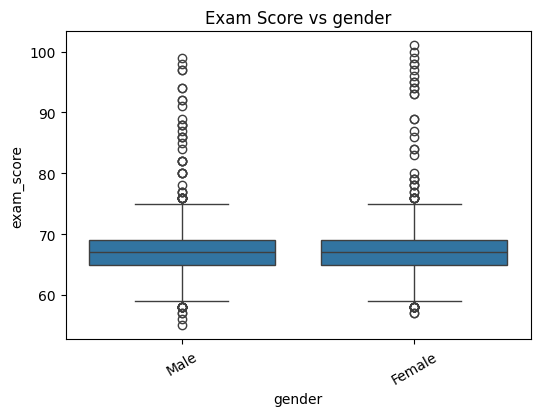

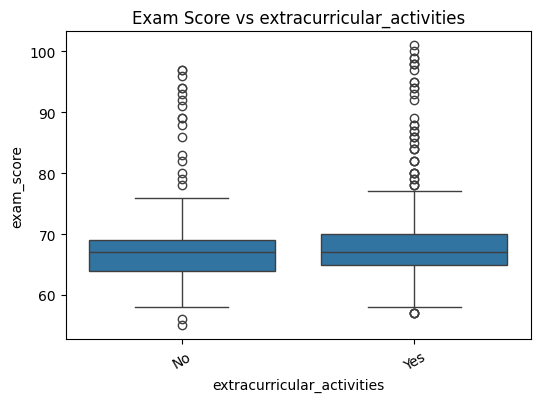

In [51]:
# Example: parental involvement, gender, extracurricular activities if exist
categorical_cols = ["parental_involvement","gender","extracurricular_activities"]
for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=df[col], y=df[target_col])
        plt.title(f"Exam Score vs {col}")
        plt.xticks(rotation=30)
        plt.show()



In [52]:
X = df[[hours_col]]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

print("Linear Regression:", metrics(y_test, pred_lin))


Linear Regression: {'MAE': 2.4475687452945643, 'MSE': 10.85592128879332, 'RMSE': np.float64(3.294832513010839), 'R2': 0.2319868674542106}


Polynomial Regression (deg=2): {'MAE': 2.4447795821288105, 'MSE': 10.84498813570501, 'RMSE': np.float64(3.2931729586684346), 'R2': 0.23276034442853466}


c:\Users\Specialist\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


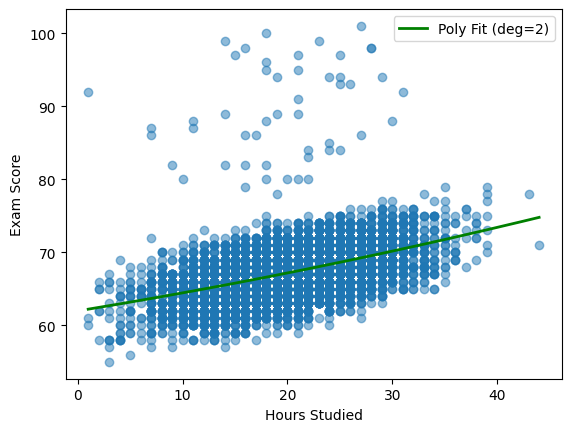

In [54]:
poly = Pipeline([("poly", PolynomialFeatures(degree=2, include_bias=False)),
                 ("lin", LinearRegression())])

poly.fit(X_train, y_train)
pred_poly = poly.predict(X_test)

print("Polynomial Regression (deg=2):", metrics(y_test, pred_poly))

# Plot polynomial curve
x_grid = np.linspace(df[hours_col].min(), df[hours_col].max(), 200).reshape(-1,1)
y_grid = poly.predict(x_grid)

plt.scatter(df[hours_col], df[target_col], alpha=0.5)
plt.plot(x_grid, y_grid, color="green", linewidth=2, label="Poly Fit (deg=2)")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.legend()
plt.show()


In [58]:
# Possible features
possible_numeric = ["hours_studied","sleep_hours","attendance","previous_scores"]
possible_categorical = ["parental_involvement","extracurricular_activities","gender"]

num_feats = [c for c in possible_numeric if c in df.columns and c != target_col]
cat_feats = [c for c in possible_categorical if c in df.columns]

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)

if num_feats or cat_feats:
    features = num_feats + cat_feats
    X_full = df[features].copy()
    y_full = df[target_col]

    # Fill NaNs
    for n in num_feats:
        X_full[n] = pd.to_numeric(X_full[n], errors="coerce").fillna(X_full[n].mean())
    for c in cat_feats:
        X_full[c] = X_full[c].fillna("missing").astype(str)

    # Preprocessor
    num_transformer = Pipeline([("scaler", StandardScaler())])
    cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    pre = ColumnTransformer(
        transformers=[("num", num_transformer, num_feats),
                      ("cat", cat_transformer, cat_feats)]
    )

    rf = RandomForestRegressor(random_state=42)
    pipe_rf = Pipeline([("pre", pre), ("rf", rf)])

    param_dist = {
        "rf__n_estimators": [100,200,400],
        "rf__max_depth": [None,5,10,20],
        "rf__min_samples_split": [2,5,10],
        "rf__min_samples_leaf": [1,2,4]
    }

    rnd = RandomizedSearchCV(pipe_rf, param_distributions=param_dist,
                             n_iter=10, cv=5,
                             scoring="neg_root_mean_squared_error",
                             random_state=42, n_jobs=-1)
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
    rnd.fit(X_train_f, y_train_f)
    best_rf = rnd.best_estimator_
    pred_rf = best_rf.predict(X_test_f)

    print("RandomForest best params:", rnd.best_params_)
    print("RandomForest:", metrics(y_test_f, pred_rf))


Numeric features: ['hours_studied', 'sleep_hours', 'attendance', 'previous_scores']
Categorical features: ['parental_involvement', 'extracurricular_activities', 'gender']
RandomForest best params: {'rf__n_estimators': 400, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 4, 'rf__max_depth': 10}
RandomForest: {'MAE': 1.3449282833411385, 'MSE': 5.362412641426339, 'RMSE': np.float64(2.315688373125006), 'R2': 0.6206306935002879}


In [60]:
try:
    from xgboost import XGBRegressor

    xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
    pipe_xgb = Pipeline([("pre", pre), ("xgb", xgb)])

    param_dist_xgb = {
        "xgb__n_estimators":[100,200,400],
        "xgb__max_depth":[3,6,10],
        "xgb__learning_rate":[0.01,0.05,0.1],
        "xgb__subsample":[0.6,0.8,1.0]
    }

    rnd_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist_xgb,
                                 n_iter=10, cv=5,
                                 scoring="neg_root_mean_squared_error",
                                 random_state=42, n_jobs=-1)
    rnd_xgb.fit(X_train_f, y_train_f)
    best_xgb = rnd_xgb.best_estimator_
    pred_xgb = best_xgb.predict(X_test_f)

    print("XGBoost best params:", rnd_xgb.best_params_)
    print("XGBoost:", metrics(y_test_f, pred_xgb))
except ImportError:
    print("XGBoost not installed in this environment.")


XGBoost best params: {'xgb__subsample': 0.6, 'xgb__n_estimators': 200, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.05}
XGBoost: {'MAE': 1.2884880304336548, 'MSE': 5.039817810058594, 'RMSE': np.float64(2.244953854772653), 'R2': 0.6434530019760132}


In [61]:
# Collect all metrics into one table
results = []
results.append(("Linear_hours", metrics(y_test, pred_lin)))
results.append(("Polynomial_deg2_hours", metrics(y_test, pred_poly)))

if num_feats or cat_feats:
    results.append(("RandomForest_multi", metrics(y_test_f, pred_rf)))
    try:
        results.append(("XGBoost_multi", metrics(y_test_f, pred_xgb)))
    except:
        pass

pd.DataFrame([{**{"Model":name}, **m} for name,m in results])


,Model,MAE,MSE,RMSE,R2
0,Linear_hours,2.447569,10.855921,3.294833,0.231987
1,Polynomial_deg2_hours,2.444780,10.844988,3.293173,0.232760
2,RandomForest_multi,1.344928,5.362413,2.315688,0.620631
3,XGBoost_multi,1.288488,5.039818,2.244954,0.643453
